# Librairies

In [ ]:
import tensorflow_hub as hub
from os import listdir
from os.path import isfile, join
import tarfile
import os
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Loading data

Images are on a tar file. We need to extract them first.

In [ ]:
# extracting files
files = tarfile.open("/content/drive/MyDrive/DATASETS/ML/P6/images.tar")
files.extractall()

In [ ]:
# setting folder for loading images for models
dir = "/content/Images"

# Train, validation split

In [ ]:
# Setting image resolution for MobilNet
IMAGE_RES = 224
# Setting batch size
BATCH_SIZE = 32

In [ ]:
# Spliting training set
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES ,IMAGE_RES),
    shuffle=True,
    seed=78,
    validation_split=0.33,
    subset="training",
    interpolation="bilinear",
    follow_links=False
)

Found 20580 files belonging to 120 classes.
Using 13789 files for training.


In [ ]:
# spliting validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES ,IMAGE_RES),
    shuffle=True,
    seed=78,
    validation_split=0.33,
    subset="validation",
    interpolation="bilinear",
    follow_links=False
)

Found 20580 files belonging to 120 classes.
Using 6791 files for validation.


In [ ]:
# Computing number of classes
num_classes = len(training_set.class_names)

# Computing number of batch
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Batchs: {}'.format(num_training_examples))
print('Total Number of Validation Batchs: {} \n'.format(num_validation_examples))

Total Number of Classes: 120
Total Number of Training Batchs: 431
Total Number of Validation Batchs: 213 



# Preprocessing

In [ ]:
# rescaling images
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).prefetch(1)

validation_batches = validation_set.map(format_image).prefetch(1)

# Loading MobilNet

In [ ]:
# Loading model from tensorflow hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

# Setting pretrained model to no trainable
feature_extractor.trainable = False

# Raw model

In [ ]:
# creating model
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation = "softmax")
])
# compile model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:



# Create a callback that saves the model's weights
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
# Create a callback that stops fitting when val loss do not decrease
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# number of epochs
EPOCHS = 200

# fitting model
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback,cp_callback])

Epoch 1/200
431/431 [==============================] - 63s 111ms/step - loss: 2.0190 - accuracy: 0.5512 - val_loss: 0.6148 - val_accuracy: 0.8096

Epoch 00001: val_loss improved from inf to 0.61480, saving model to training_1/cp.ckpt
Epoch 2/200
431/431 [==============================] - 53s 108ms/step - loss: 0.4050 - accuracy: 0.8804 - val_loss: 0.5494 - val_accuracy: 0.8223

Epoch 00002: val_loss improved from 0.61480 to 0.54942, saving model to training_1/cp.ckpt
Epoch 3/200
431/431 [==============================] - 53s 108ms/step - loss: 0.2525 - accuracy: 0.9295 - val_loss: 0.5339 - val_accuracy: 0.8284

Epoch 00003: val_loss improved from 0.54942 to 0.53387, saving model to training_1/cp.ckpt
Epoch 4/200
431/431 [==============================] - 53s 109ms/step - loss: 0.1748 - accuracy: 0.9602 - val_loss: 0.5330 - val_accuracy: 0.8326

Epoch 00004: val_loss improved from 0.53387 to 0.53302, saving model to training_1/cp.ckpt
Epoch 5/200
431/431 [==============================]

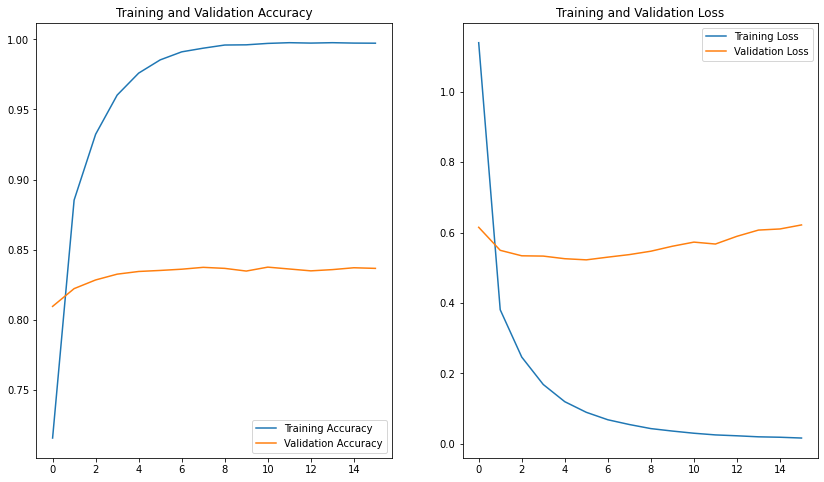

In [ ]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
# model scoring
model.evaluate(validation_batches)

213/213 [==============================] - 17s 77ms/step - loss: 0.5224 - accuracy: 0.8352


[0.5223565697669983, 0.8352230787277222]

Clear ovefitting. We will try differents approach to reduce overfitting :
* Adding a dense layer
* Image augmentation
* Dropout layer
* Normalisation

# Dense

In [ ]:
# create model
model = tf.keras.Sequential([
  feature_extractor,

  layers.Dense(640, activation = "relu"),

  layers.Dense(num_classes, activation = "softmax")
])

# compile model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 640)               819840    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               76920     
Total params: 3,154,744
Trainable params: 896,760
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# fitting model
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback,cp_callback])

Epoch 1/200
431/431 [==============================] - 53s 106ms/step - loss: 1.7301 - accuracy: 0.5892 - val_loss: 0.7110 - val_accuracy: 0.7775

Epoch 00001: val_loss improved from inf to 0.71100, saving model to training_2/cp.ckpt
Epoch 2/200
431/431 [==============================] - 52s 105ms/step - loss: 0.4410 - accuracy: 0.8557 - val_loss: 0.7141 - val_accuracy: 0.7859

Epoch 00002: val_loss did not improve from 0.71100
Epoch 3/200
431/431 [==============================] - 51s 105ms/step - loss: 0.2692 - accuracy: 0.9123 - val_loss: 0.6886 - val_accuracy: 0.8006

Epoch 00003: val_loss improved from 0.71100 to 0.68857, saving model to training_2/cp.ckpt
Epoch 4/200
431/431 [==============================] - 51s 104ms/step - loss: 0.1725 - accuracy: 0.9437 - val_loss: 0.7219 - val_accuracy: 0.8042

Epoch 00004: val_loss did not improve from 0.68857
Epoch 5/200
431/431 [==============================] - 51s 104ms/step - loss: 0.1075 - accuracy: 0.9667 - val_loss: 0.7500 - val_acc

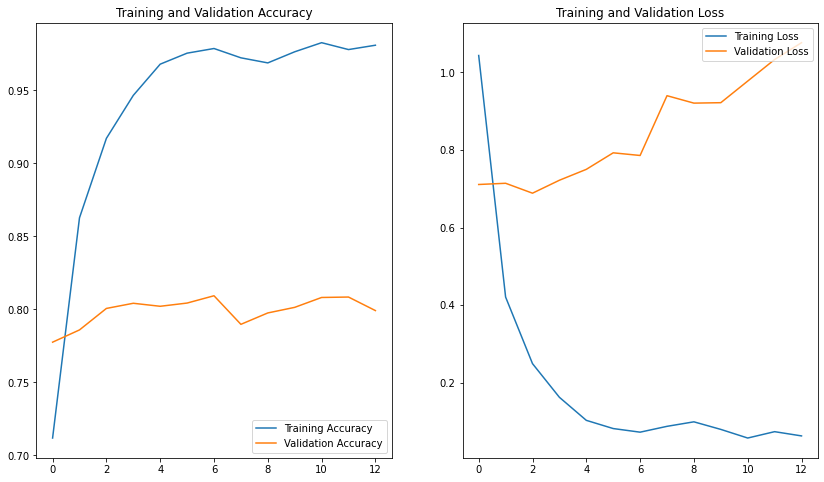

In [ ]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
# model scoring
model.evaluate(validation_batches)

213/213 [==============================] - 17s 76ms/step - loss: 0.6886 - accuracy: 0.8006


[0.6885679960250854, 0.8006184697151184]

# image augmentation

In [ ]:
# creating image generator for train split
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.33)

# creating image generator for validation split
image_gen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.33)

# creating train validation split
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='binary',
                                                     subset='training')

validation_generator = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='binary',
                                                     subset='validation')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 13846 images belonging to 120 classes.
Found 6734 images belonging to 120 classes.


In [ ]:
# creating model
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation = "softmax")
])
# compile model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# fitting model
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[callback,cp_callback])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
433/433 [==============================] - 203s 466ms/step - loss: 2.9012 - accuracy: 0.3439 - val_loss: 0.8221 - val_accuracy: 0.7649

Epoch 00001: val_loss improved from inf to 0.82214, saving model to training_3/cp.ckpt
Epoch 2/200
433/433 [==============================] - 199s 461ms/step - loss: 1.3046 - accuracy: 0.6309 - val_loss: 0.7002 - val_accuracy: 0.7836

Epoch 00002: val_loss improved from 0.82214 to 0.70024, saving model to training_3/cp.ckpt
Epoch 3/200
433/433 [==============================] - 200s 461ms/step - loss: 1.1654 - accuracy: 0.6630 - val_loss: 0.6738 - val_accuracy: 0.7918

Epoch 00003: val_loss improved from 0.70024 to 0.67376, saving model to training_3/cp.ckpt
Epoch 4/200
433/433 [==============================] - 198s 457ms/step - loss: 1.0790 - accuracy: 0.6865 - val_loss: 0.6813 - val_accuracy: 0.7850

Epoch 00004: val_loss did not improve from 0.67376
Epoch 5/200
433/433 [==============================] - 198s 457ms/step - loss: 1.0074 - 

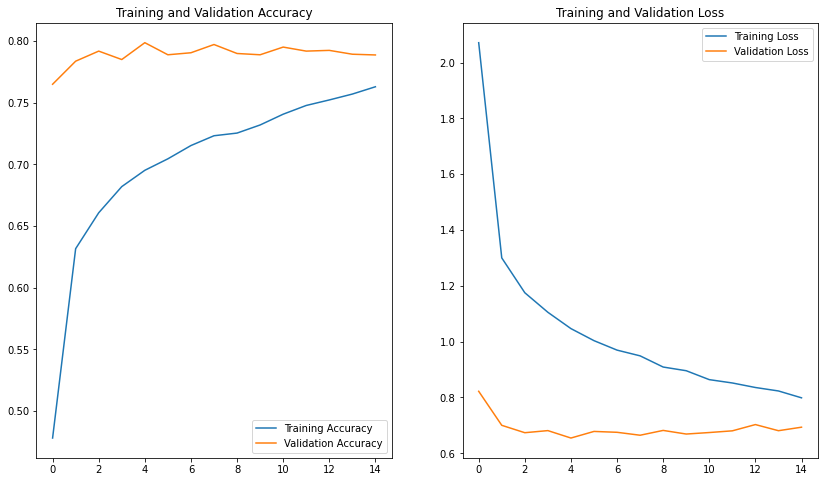

In [ ]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
# model scoring
model.evaluate(validation_generator)

211/211 [==============================] - 26s 124ms/step - loss: 0.6547 - accuracy: 0.7986


[0.6546719074249268, 0.7986338138580322]

# Drop out

In [ ]:
# creating model
model = tf.keras.Sequential([
  feature_extractor,

  tf.keras.layers.Dropout(0.2),
  
  layers.Dense(num_classes, activation = "softmax")
])
# compile model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# fitting model 
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback,cp_callback])

Epoch 1/200
431/431 [==============================] - 52s 105ms/step - loss: 2.1551 - accuracy: 0.5171 - val_loss: 0.6165 - val_accuracy: 0.8124

Epoch 00001: val_loss improved from inf to 0.61655, saving model to training_4/cp.ckpt
Epoch 2/200
431/431 [==============================] - 51s 103ms/step - loss: 0.4498 - accuracy: 0.8679 - val_loss: 0.5649 - val_accuracy: 0.8214

Epoch 00002: val_loss improved from 0.61655 to 0.56487, saving model to training_4/cp.ckpt
Epoch 3/200
431/431 [==============================] - 51s 103ms/step - loss: 0.3096 - accuracy: 0.9084 - val_loss: 0.5287 - val_accuracy: 0.8323

Epoch 00003: val_loss improved from 0.56487 to 0.52870, saving model to training_4/cp.ckpt
Epoch 4/200
431/431 [==============================] - 51s 103ms/step - loss: 0.2353 - accuracy: 0.9286 - val_loss: 0.5387 - val_accuracy: 0.8299

Epoch 00004: val_loss did not improve from 0.52870
Epoch 5/200
431/431 [==============================] - 51s 104ms/step - loss: 0.1769 - accur

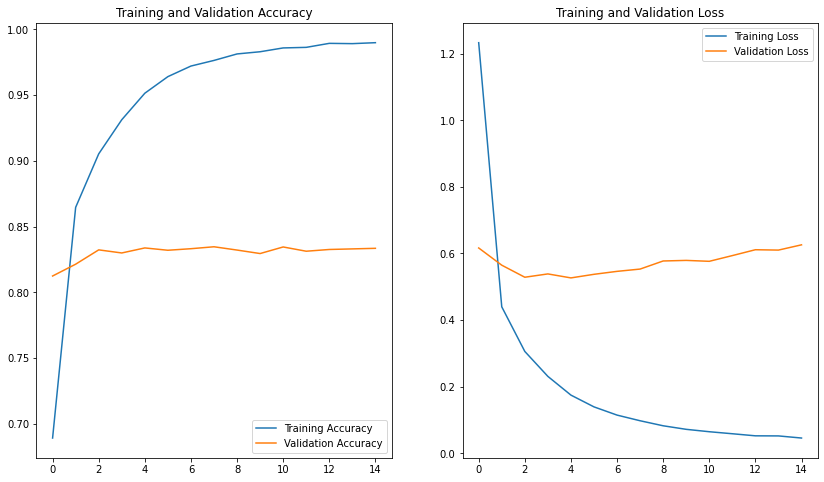

In [ ]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
# model scoring
model.evaluate(validation_batches)

213/213 [==============================] - 16s 75ms/step - loss: 0.5267 - accuracy: 0.8338


[0.5266867280006409, 0.8337505459785461]

# Batch normalisation

In [ ]:
# creating model
model = tf.keras.Sequential([
  feature_extractor,

  tf.keras.layers.BatchNormalization(),
  
  layers.Dense(num_classes, activation = "softmax")
])

# compile model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense_5 (Dense)              (None, 120)               153720    
Total params: 2,416,824
Trainable params: 156,280
Non-trainable params: 2,260,544
_________________________________________________________________


In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "training_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# fitting model
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback,cp_callback])

Epoch 1/200
431/431 [==============================] - 52s 104ms/step - loss: 1.8768 - accuracy: 0.5520 - val_loss: 0.6325 - val_accuracy: 0.8072

Epoch 00001: val_loss improved from inf to 0.63254, saving model to training_5/cp.ckpt
Epoch 2/200
431/431 [==============================] - 51s 104ms/step - loss: 0.3683 - accuracy: 0.8836 - val_loss: 0.6166 - val_accuracy: 0.8170

Epoch 00002: val_loss improved from 0.63254 to 0.61655, saving model to training_5/cp.ckpt
Epoch 3/200
431/431 [==============================] - 51s 103ms/step - loss: 0.2196 - accuracy: 0.9304 - val_loss: 0.6131 - val_accuracy: 0.8198

Epoch 00003: val_loss improved from 0.61655 to 0.61307, saving model to training_5/cp.ckpt
Epoch 4/200
431/431 [==============================] - 51s 104ms/step - loss: 0.1400 - accuracy: 0.9563 - val_loss: 0.6284 - val_accuracy: 0.8277

Epoch 00004: val_loss did not improve from 0.61307
Epoch 5/200
431/431 [==============================] - 51s 104ms/step - loss: 0.0953 - accur

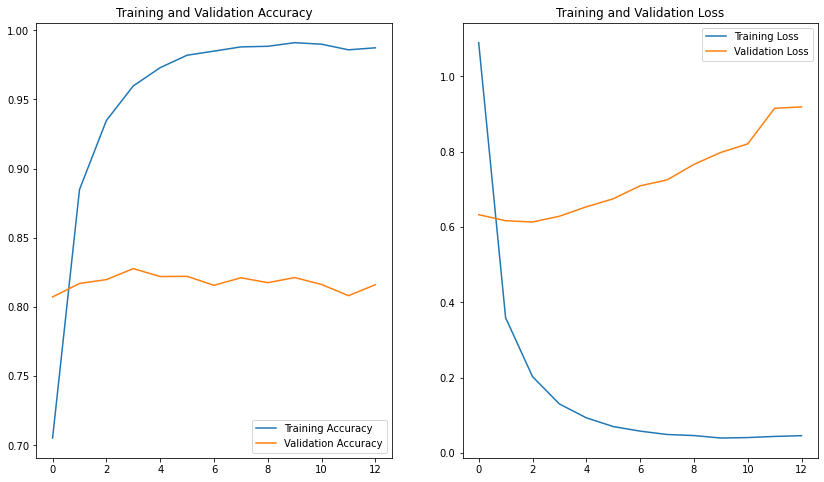

In [ ]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
# model scoring
model.evaluate(validation_batches)

213/213 [==============================] - 17s 76ms/step - loss: 0.6131 - accuracy: 0.8198


[0.6130686402320862, 0.8197614550590515]

# Predict

In [ ]:
# loading best model 
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [ ]:
class_names = training_set.class_names

# Cleaning class names 
class_names_clean = []
for c in class_names:  
  first, second = c.split("-", maxsplit =1)
  class_names_clean.append(second)

type(class_names_clean)
type(np.asarray(class_names_clean))

class_names_clean = np.asarray(class_names_clean)

In [ ]:
# separate images and label
image_batch, label_batch = next(iter(validation_batches))

In [ ]:
# make a prediction 
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names_clean[predicted_ids]
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            tf.Tensor(
[ 78  74  92  97  40   9  73  92  75  95  88  97  85  40  11 104  12  62
  21  80  59   2 116  66  77  60  91  85  20  22  91  21], shape=(32,), dtype=int32)
Predicted labels:  [ 78  74  92  23  40  25  73  92  75  95  88  99  95  40  11  73  12  62
  21  79  59   2 116  66  77  60   8  83  21  22  91  21]


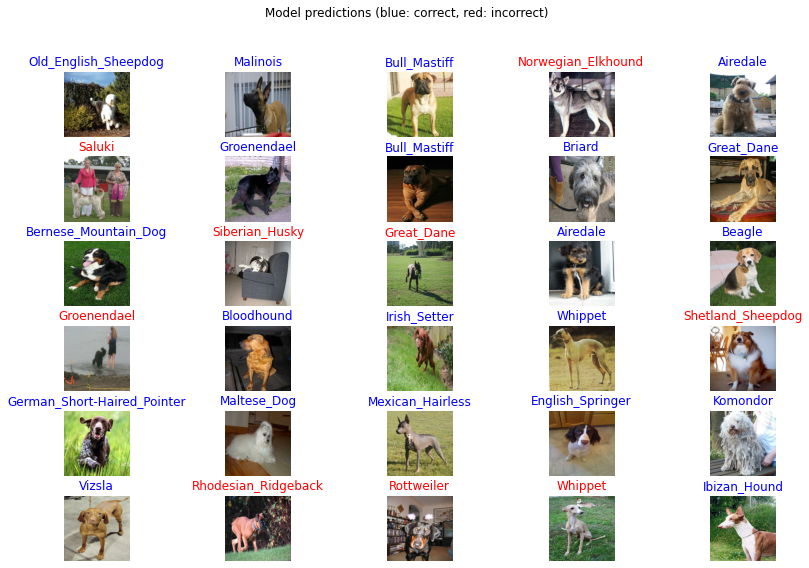

In [ ]:
# plotting predicted images
plt.figure(figsize=(14,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Export

In [ ]:
import time

t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1614186636.h5


In [ ]:
np.save("/content/drive/MyDrive/app/class_names_clean",class_names_clean)

In [ ]:
export_path_keras

'./1614186636.h5'

# API

https://dogs-prediction.herokuapp.com/
